In [1]:
import pandas as pd

data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')



План выполнения работы

1) Предобработать данные

2) Объединить в единый датасет

3) Разбить на тестовую, валидную и обучащую выборки

4) Выбрать подходящую модель и вывести нужную стандартную ошибку

In [2]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [3]:
print(data_arc.info())
#Переведем даты в формат дат
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

data_arc.head()
data_sup = data_arc.groupby(['key']).agg({'Конец нагрева дугой':'max'}).reset_index()
data_sup['flg'] = 1
data_arc = data_arc.merge(data_sup, on = ['key','Конец нагрева дугой'], how = 'left')
data_arc.head(10)
data_arc = data_arc.query('flg == 1')
data_arc = data_arc[['key','Активная мощность','Реактивная мощность']]
data_arc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


,key,Активная мощность,Реактивная мощность
4,1,0.692755,0.414397
8,2,0.827743,0.516874
13,3,0.250280,0.155901
17,4,1.220955,0.754719
21,5,0.267457,0.181992
...,...,...,...
14854,3237,0.606049,0.419084
14857,3238,0.717559,0.520623
14865,3239,0.488352,0.317727
14870,3240,0.548882,0.416994


Привет, да. Здесь беру последнее значение партии , тк смотрим на последнее значение температуры как целевой таргет, поэтому брать последние мощности для модели будет корректно, я думаю. Оставил key, чтобы корректно смерджить с остальными 

In [4]:
data_bulk = data_bulk.fillna(0)
data_bulk = data_bulk[['key','Bulk 12','Bulk 14','Bulk 15']]
data_bulk

,key,Bulk 12,Bulk 14,Bulk 15
0,1,206.0,150.0,154.0
1,2,206.0,149.0,154.0
2,3,205.0,152.0,153.0
3,4,207.0,153.0,154.0
4,5,203.0,151.0,152.0
...,...,...,...,...
3124,3237,252.0,130.0,206.0
3125,3238,254.0,108.0,106.0
3126,3239,158.0,270.0,88.0
3127,3240,0.0,192.0,54.0


Оставили только три ковша, потому что остальные пустые значения тк скорее всего были сбои и мы не знаем как объемы там содержались и соотвественно никакой информации нам это не дает и опускаем их

In [5]:
data_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [6]:
data_s = data_temp.groupby('key')['Время замера'].max().reset_index()
data_s['flg'] = 1
data_temp = data_temp.merge(data_s, on = ['key','Время замера'], how = 'left')
data_temp = data_temp.query('flg == 1').reset_index()
data_temp = data_temp[['key','Температура']]
data_temp = data_temp.dropna()
data_temp

,key,Температура
0,1,1613.0
1,2,1602.0
2,3,1599.0
3,4,1625.0
4,5,1602.0
...,...,...
2472,2495,1591.0
2473,2496,1591.0
2474,2497,1589.0
2475,2498,1594.0


Берем последнюю температуру, тк ее предсказывать и будем в партиях, соотвественно ее оставляем , а пропуски с партиями удаляем все

In [7]:
print(data_wire.info())
data_wire.head()
data_wire = data_wire[['key','Wire 1','Wire 2']]
data_wire = data_wire.fillna(0)
data_wire

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


,key,Wire 1,Wire 2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456
...,...,...,...
3076,3237,38.088959,0.00000
3077,3238,56.128799,0.00000
3078,3239,143.357761,0.00000
3079,3240,34.070400,0.00000


Тут аналогично с Bulk

In [8]:
#data_wire_time и data_bulk_time не нужны для модели тк в ней отсутсвуют признаки для предсказывания температуры
all_data = data_temp.merge(data_arc, on = 'key', how = 'left').merge(data_bulk, on = 'key', how = 'left').merge(data_gas, on = 'key', how = 'left').merge(data_wire, on = 'key', how = 'left')

all_data = all_data.rename({'Температура':'temp'},axis=1)
all_data.head(10)

,key,temp,Активная мощность,Реактивная мощность,Bulk 12,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2
0,1,1613.0,0.692755,0.414397,206.0,150.0,154.0,29.749986,60.059998,0.000000
1,2,1602.0,0.827743,0.516874,206.0,149.0,154.0,12.555561,96.052315,0.000000
2,3,1599.0,0.250280,0.155901,205.0,152.0,153.0,28.554793,91.160157,0.000000
3,4,1625.0,1.220955,0.754719,207.0,153.0,154.0,18.841219,89.063515,0.000000
4,5,1602.0,0.267457,0.181992,203.0,151.0,152.0,5.413692,89.238236,9.114560
5,6,1596.0,1.197724,0.743763,204.0,201.0,154.0,11.273392,99.109917,9.114560
6,7,1599.0,0.378760,0.234998,204.0,152.0,154.0,9.836267,98.061600,0.000000
7,8,1598.0,0.282020,0.178295,410.0,252.0,153.0,15.171553,155.282394,0.000000
8,9,1592.0,0.141432,0.097034,107.0,99.0,203.0,8.216623,113.393279,9.143681
9,10,1593.0,0.364017,0.272531,203.0,102.0,204.0,6.529891,81.244796,12.376000


In [9]:
all_data = all_data.query('temp.notnull()')
all_data.info()
all_data = all_data.drop('key',axis=1)
all_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 10 columns):
key                    2477 non-null int64
temp                   2477 non-null float64
Активная мощность      2475 non-null float64
Реактивная мощность    2475 non-null float64
Bulk 12                2408 non-null float64
Bulk 14                2408 non-null float64
Bulk 15                2408 non-null float64
Газ 1                  2475 non-null float64
Wire 1                 2373 non-null float64
Wire 2                 2373 non-null float64
dtypes: float64(9), int64(1)
memory usage: 212.9 KB


,temp,Активная мощность,Реактивная мощность,Bulk 12,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2
0,1613.0,0.692755,0.414397,206.0,150.0,154.0,29.749986,60.059998,0.00000
1,1602.0,0.827743,0.516874,206.0,149.0,154.0,12.555561,96.052315,0.00000
2,1599.0,0.250280,0.155901,205.0,152.0,153.0,28.554793,91.160157,0.00000
3,1625.0,1.220955,0.754719,207.0,153.0,154.0,18.841219,89.063515,0.00000
4,1602.0,0.267457,0.181992,203.0,151.0,152.0,5.413692,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...
2472,1591.0,0.435236,0.304878,256.0,129.0,223.0,7.125735,89.150879,0.00000
2473,1591.0,1.049800,0.701201,256.0,129.0,226.0,9.412616,114.179527,0.00000
2474,1589.0,0.796857,0.645539,230.0,124.0,226.0,6.271699,94.086723,9.04800
2475,1594.0,0.180213,0.116065,206.0,129.0,207.0,14.953657,118.110717,0.00000


Предобработали и создали единый датасет с признаками и целевым таргетом

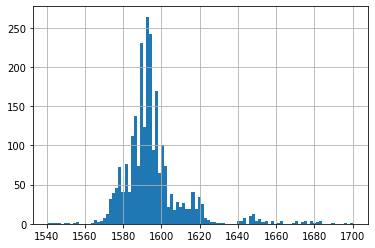

In [10]:
import matplotlib.pyplot as plt

all_data['temp'].hist(bins=100)
plt.show()

Видим, что основная температура находится в разрезе 1570 и 1620, возьмем для модельки тогда только эти признаки, тк остальные случае очень редки и уменьшают качество модели

In [11]:
#all_data = all_data.query('temp >= 1570 and temp <= 1620')
#all_data

In [12]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

features_train, features_valid, target_train, target_valid = train_test_split(
    all_data.drop('temp', axis=1), all_data.temp, test_size=0.25, random_state=12345)



model = CatBoostRegressor(loss_function= "MAE", iterations=200)

model.fit(features_train, target_train, verbose=20)

prob = model.predict(features_valid)
print(mean_absolute_error(target_valid, prob))

0:	learn: 9.9092290	total: 49.4ms	remaining: 9.83s
20:	learn: 9.0263998	total: 256ms	remaining: 2.18s
40:	learn: 8.4357323	total: 538ms	remaining: 2.09s
60:	learn: 8.0647569	total: 829ms	remaining: 1.89s
80:	learn: 7.7560643	total: 1.12s	remaining: 1.64s
100:	learn: 7.5338995	total: 1.41s	remaining: 1.38s
120:	learn: 7.3694636	total: 1.7s	remaining: 1.11s
140:	learn: 7.2428498	total: 1.83s	remaining: 767ms
160:	learn: 7.1373658	total: 2.12s	remaining: 514ms
180:	learn: 7.0422692	total: 2.41s	remaining: 253ms
199:	learn: 6.9475371	total: 2.7s	remaining: 0us
7.561389858599267


Получили MAE 7.5, как требовалось по условию.
Сделали градиенттный бустинг с 200 итерациями. Взяли градиентный бустинг , так как лучше на мой взгляд модели нужно учитывать ошибки предыдущих моделей в ансамбле, которые идут по градиентному спуску.
Правда не понял, как мне вывести график feaute_importances_ ? Что это такое? Мы просто бустинг так не изучали, если речь про него

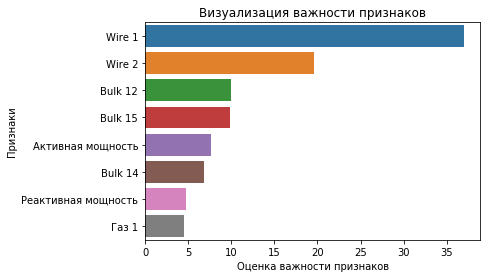

In [13]:
import seaborn as sns
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_train.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

chart_feature_imp(model)


Оставляем как есть, спасибо!